In [3]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn import metrics 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error, r2_score

import optuna
from optuna.integration import CatBoostPruningCallback

In [4]:
fe = pd.read_csv("Datasets\\prepr.csv")

In [5]:
cat_to_drop = fe.select_dtypes(include="object").columns
fe_num = fe.drop(cat_to_drop, axis=1)

In [6]:
fe_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 54 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Cat./Support ratio, % (at)                      3600 non-null   float64
 1   Pore size, nm                                   3600 non-null   float64
 2   width min (nm)                                  3600 non-null   float64
 3   width aver (nm)                                 3600 non-null   float64
 4   width max (nm)                                  3600 non-null   float64
 5   length min (nm)                                 3600 non-null   float64
 6   length aver (nm)                                3600 non-null   float64
 7   length max (nm)                                 3600 non-null   float64
 8   Cu, % (at.)                                     3600 non-null   float64
 9   Cu+, % (at.)                             

# Visualization

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

seaborn_palette = sns.color_palette("crest")

In [8]:
seaborn_palette

[(0.48942421, 0.72854938, 0.56751036),
 (0.34892097, 0.64828676, 0.56513633),
 (0.24929311, 0.56486397, 0.5586654),
 (0.15615526, 0.47913212, 0.54850526),
 (0.11131735, 0.39155635, 0.53422678),
 (0.14573579, 0.29354139, 0.49847009)]

# Data loading

In [9]:
val_sampl = ["o-Cu2O/Ag"]
val_rows = fe['Article name'].isin(val_sampl)

Xy_val = fe_num[val_rows].copy()
Xy_tt = fe_num[~val_rows].copy()

y_val = Xy_val["FE, %"].copy()
y = Xy_tt["FE, %"].copy()

X_val = Xy_val.drop(["FE, %"], axis=1)
X = Xy_tt.drop(["FE, %"], axis=1)

X.shape, y.shape

((3583, 53), (3583,))

In [10]:
len(fe_num[val_rows])

17

In [11]:
def data_augmentation(_X, _y): 
    X_train_2 = _X.copy()
    cols = list(_X.columns)
    cols_1 = [col for col in cols if col.startswith("1_")]
    print(cols_1)
    cols_2 = [col for col in cols if col.startswith("2_")]
    print(cols_2)
    X_train_2[cols_1] = _X[cols_2]

    X_train_2[cols_2] = _X[cols_1]

    X_train_2['Cat./Support ratio, % (at)'] = 100 - _X['Cat./Support ratio, % (at)']

    X_train_2 = pd.concat([_X, X_train_2])
    y_train_2 = pd.concat([_y, _y])

    return X_train_2, y_train_2

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, X_val.shape

((2866, 53), (717, 53), (17, 53))

# Splitting by RHE only

In [13]:
to_drop = ['Product_exactmw',
       'Product_lipinskiHBA', 'Product_lipinskiHBD', 'Product_NumAtoms',
       'Product_FractionCSP3', 'Product_CrippenClogP', 'Product_hallKierAlpha',
       'Product_kappa2', 'Product_kappa3', 'FE, %']

df_shr = Xy_tt.drop(to_drop, axis=1).drop_duplicates()

X_rhe_train, X_rhe_test = train_test_split(df_shr, test_size=0.2, random_state=42)
X_rhe_train.shape, X_rhe_test.shape

column_names = list(df_shr.columns)

# Уникальные комбинации значений в указанных столбцах
unique_combinations_train = list(zip(*[X_rhe_train[col] for col in column_names]))
unique_combinations_test = list(zip(*[X_rhe_test[col] for col in column_names]))

Xy_rhe_train = Xy_tt[Xy_tt[column_names].apply(tuple, axis=1).isin(unique_combinations_train)]
Xy_rhe_test = Xy_tt[Xy_tt[column_names].apply(tuple, axis=1).isin(unique_combinations_test)]

Xy_rhe_train.shape, Xy_rhe_test.shape

((2868, 54), (715, 54))

In [14]:
len(df_shr)

800

In [15]:
X_rhe_train = Xy_rhe_train.drop(["FE, %"], axis=1)
X_rhe_test = Xy_rhe_test.drop(["FE, %"], axis=1)

y_rhe_train = Xy_rhe_train["FE, %"]
y_rhe_test = Xy_rhe_test["FE, %"]

X_rhe_train, y_rhe_train = data_augmentation(X_rhe_train, y_rhe_train)

['1_efermi', '1_density_atomic', '1_total_magnetization_normalized_formula_units', '1_energy_above_hull', '1_energy_per_atom', '1_volume', '1_band_gap']
['2_efermi', '2_density_atomic', '2_total_magnetization_normalized_formula_units', '2_energy_above_hull', '2_energy_per_atom', '2_volume', '2_band_gap']


## Lazy predict

In [16]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split


# Инициализация и обучение LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_rhe_train, X_rhe_test, y_rhe_train, y_rhe_test)

# Вывод результатов
print(models)

100%|██████████| 42/42 [00:44<00:00,  1.06s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1868
[LightGBM] [Info] Number of data points in the train set: 5736, number of used features: 53
[LightGBM] [Info] Start training from score 20.609071
                                      Adjusted R-Squared  \
Model                                                      
RandomForestRegressor                               0.80   
ExtraTreesRegressor                                 0.80   
XGBRegressor                                        0.79   
BaggingRegressor                                    0.79   
HistGradientBoostingRegressor                       0.74   
LGBMRegressor                                       0.74   
ExtraTreeRegressor                                  0.73   
KNeighborsRegressor                                 0.

In [17]:
models_sorted = models.sort_values(by="RMSE", ascending=True)

# Вывод топ-10 моделей по RMSE
print("Топ-10 моделей по RMSE:")
print(models_sorted[['RMSE', 'R-Squared', 'Time Taken']].head(10))

Топ-10 моделей по RMSE:
                               RMSE  R-Squared  Time Taken
Model                                                     
RandomForestRegressor          8.38       0.82        6.82
ExtraTreesRegressor            8.53       0.81        4.37
XGBRegressor                   8.60       0.81        0.67
BaggingRegressor               8.68       0.80        0.75
HistGradientBoostingRegressor  9.56       0.76        0.51
LGBMRegressor                  9.56       0.76        0.44
ExtraTreeRegressor             9.90       0.75        0.07
KNeighborsRegressor           10.15       0.73        0.24
DecisionTreeRegressor         10.34       0.72        0.12
MLPRegressor                  11.32       0.67        6.61


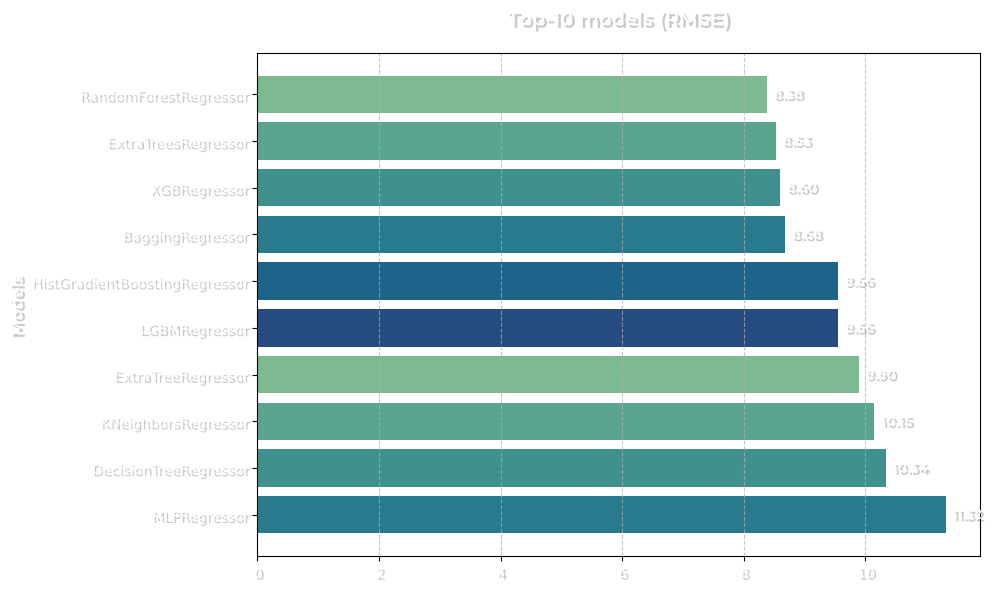

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(models_sorted.index[:10], models_sorted['RMSE'][:10], color=seaborn_palette )

plt.rcdefaults()
# plt.rcParams.update({
#     'font.family': 'Montserrat',  # Название шрифта
#     'font.size': 20,
#     'font.weight': 'bold',
#     'ytick.color': 'red',
#     # 'font.color': 'white'
# })              # Базовый размер шрифта

yticks_labels = ax.get_yticklabels()
xticks_labels = ax.get_xticklabels()

# Применяем тень к каждой метке
for label in yticks_labels:
    label.set_color('white')
    label.set_path_effects([
        path_effects.withSimplePatchShadow(
        )
    ])

# Применяем тень к каждой метке
for label in xticks_labels:
    label.set_color('white')
    label.set_path_effects([
        path_effects.withSimplePatchShadow(
        )
    ])

# Добавление значений RMSE на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1,  # Смещение текста от столбца
             bar.get_y() + bar.get_height()/2,  # Вертикальное выравнивание
             f'{width:.2f}', 
             ha='left', va='center',
             fontsize=10,
             fontfamily= 'Montserrat',
             weight= 'bold',
             color = 'white',
             path_effects=[path_effects.withSimplePatchShadow()]
        #          textprops={
        # 'fontsize': 35,
        # 'fontfamily': 'Montserrat',
        # 'weight': 'bold',
        # 'color': 'white',
    )

# Настройка внешнего вида
plt.title('Top-10 models (RMSE)', fontsize=14, pad=20, 
        fontfamily= 'Montserrat',
        weight= 'bold',
        color = 'white',
        path_effects=[path_effects.withSimplePatchShadow()])

plt.ylabel('Models', fontsize=12, 
        fontfamily= 'Montserrat',
        weight= 'bold',
        color = 'white',
        path_effects=[path_effects.withSimplePatchShadow()])

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Лучшие модели вверху
plt.tight_layout()
plt.savefig('barmodel_transparent.png', transparent=True, dpi=300, bbox_inches='tight')

plt.show()

# Catboost

In [20]:
from sklearn.metrics import mean_squared_error
import matplotlib

# Load your dataset
df = pd.read_csv('Datasets\prepr.csv')

# Define features and target
target = 'FE, %'  # Target variable
features = [col for col in df.columns if col != target and col not in ['DOI', 'Article name']]
cat_features = ['Compound_1', 'Compound_2', 'Morphology (TEM/SEM)', 'Base', 'electrolyte', 'Type of reactor', 'Product']

# Split data: 90% train-validation, 10% test
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Further split train-validation: 80% train, 20% validation
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# Define best parameters from Optuna
best_params = {
    'depth': 10,
    'learning_rate': 0.12423554533550984,
    'n_estimators': 837,
    'min_child_samples': 8,
    'subsample': 0.9190023548320605,
    'colsample_bylevel': 0.7790953650223124,
    'l2_leaf_reg': 0.8014670183436137,
    'random_strength': 0.001655734641594045,
    'bootstrap_type': 'Bernoulli',
    'random_seed': 42,
    'verbose': 100
}

# Train model on train set
model = CatBoostRegressor(**best_params)
train_pool = Pool(data=train_df[features], label=train_df[target], cat_features=cat_features)
val_pool = Pool(data=val_df[features], label=val_df[target], cat_features=cat_features)
test_pool = Pool(data=test_df[features], label=test_df[target], cat_features=cat_features)
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)

# Generate predictions for train, validation, and test sets
train_predictions = model.predict(train_pool)
val_predictions = model.predict(val_pool)
test_predictions = model.predict(test_pool)

# Calculate metrics for train, validation, and test sets
train_rmse = root_mean_squared_error(train_df[target], train_predictions)
train_mse = mean_squared_error(train_df[target], train_predictions)
train_r2 = r2_score(train_df[target], train_predictions)

val_rmse = root_mean_squared_error(val_df[target], val_predictions)
val_mse = mean_squared_error(val_df[target], val_predictions)
val_r2 = r2_score(val_df[target], val_predictions)

test_rmse = root_mean_squared_error(test_df[target], test_predictions)
test_mse = mean_squared_error(test_df[target], test_predictions)
test_r2 = r2_score(test_df[target], test_predictions)

# Create results DataFrame
metrics = {
    'Set': ['Train', 'Validation', 'Test'],
    'RMSE': [train_rmse, val_rmse, test_rmse],
    'MSE': [train_mse, val_mse, test_mse],
    'R²': [train_r2, val_r2, test_r2]
}
results_df = pd.DataFrame(metrics)
print("\nModel Performance Metrics:")
print(results_df.to_string(index=False))

0:	learn: 19.1391978	test: 19.2213950	best: 19.2213950 (0)	total: 221ms	remaining: 3m 4s
100:	learn: 4.9968569	test: 9.4416083	best: 9.4416083 (100)	total: 6.84s	remaining: 49.8s
200:	learn: 3.1528221	test: 8.9815565	best: 8.9798390 (198)	total: 13.4s	remaining: 42.3s
300:	learn: 2.1698079	test: 8.8490773	best: 8.8457721 (288)	total: 19.7s	remaining: 35.1s
400:	learn: 1.5644796	test: 8.7582422	best: 8.7563961 (398)	total: 26.2s	remaining: 28.5s
500:	learn: 1.1653362	test: 8.7338708	best: 8.7338708 (500)	total: 32.9s	remaining: 22.1s
600:	learn: 0.8777169	test: 8.7246017	best: 8.7190928 (577)	total: 39.7s	remaining: 15.6s
700:	learn: 0.6683334	test: 8.7065972	best: 8.7031927 (689)	total: 46.1s	remaining: 8.95s
800:	learn: 0.5248609	test: 8.7001779	best: 8.7000828 (799)	total: 53.4s	remaining: 2.4s
836:	learn: 0.4867967	test: 8.7014634	best: 8.6986219 (809)	total: 55.9s	remaining: 0us

bestTest = 8.6986219
bestIteration = 809

Shrink model to first 810 iterations.

Model Performance Metr

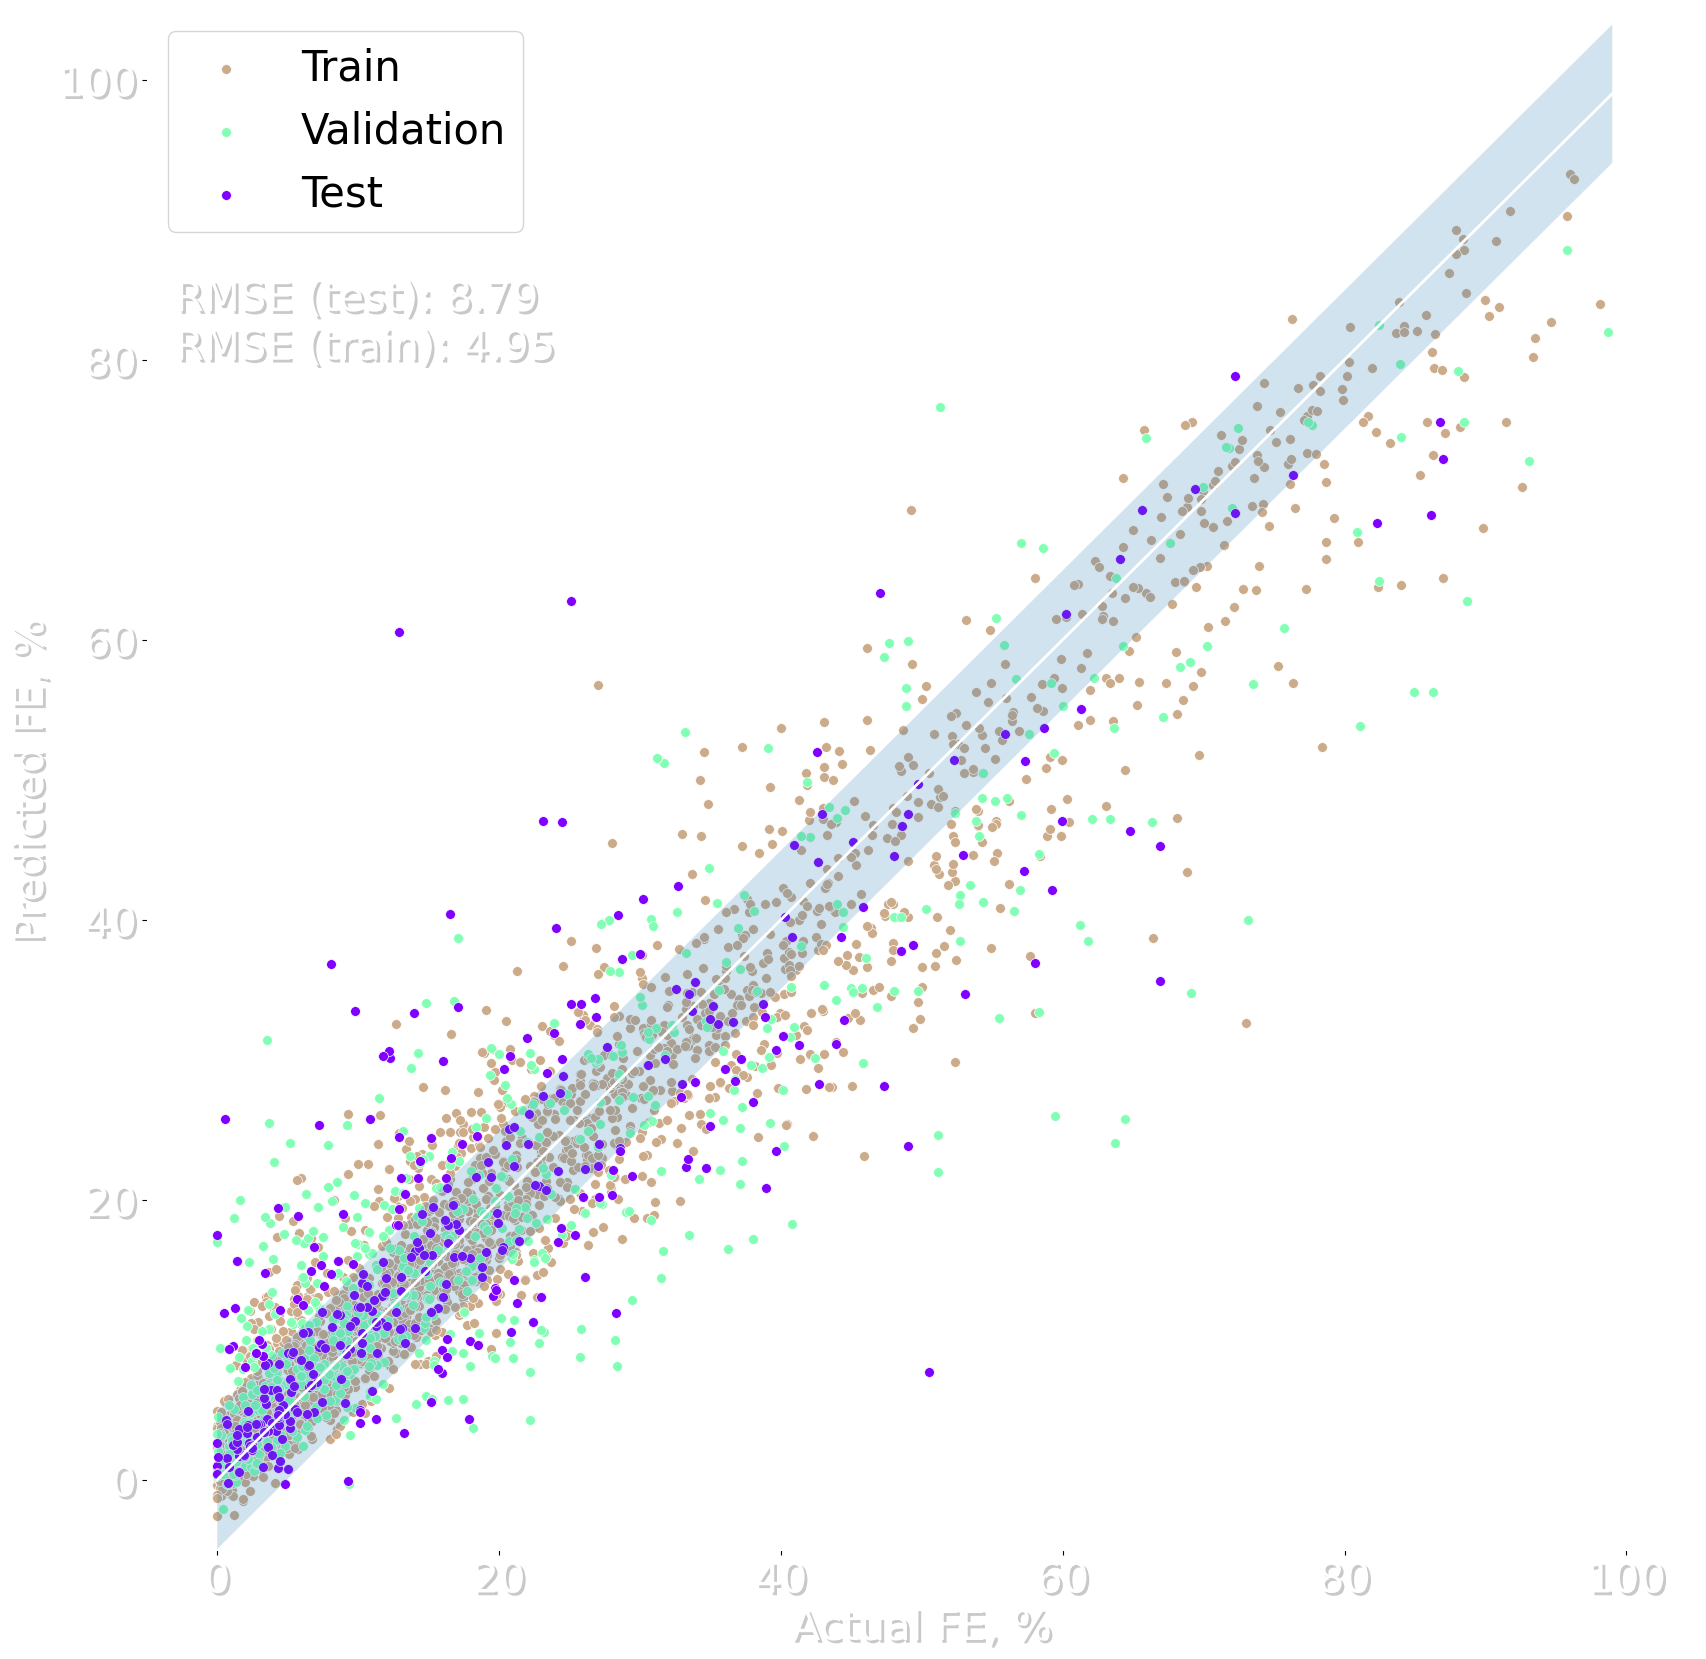

In [22]:
import matplotlib.cm as cm

# Scatter plot for train, validation, and test
plt.style.use('default')  # Reset to default style
f, ax = plt.subplots(figsize=(20, 20))
matplotlib.rcParams.update({'font.size': 22})

# Define colors using rainbow colormap
colors = cm.rainbow(np.linspace(0, 1, 3))

# Plot identity line
plt.plot([0, 100], [0, 100], color='white', linewidth=2)

# Scatter plots for train, validation, and test
plt.scatter(train_df[target], train_predictions, label="Train", color='#ccab8b', s=50, edgecolor='white', linewidth=0.5)
plt.scatter(val_df[target], val_predictions, label="Validation", color=colors[1], s=50, edgecolor='white', linewidth=0.5)
plt.scatter(test_df[target], test_predictions, label="Test", color=colors[0], s=50, edgecolor='white', linewidth=0.5)

# Shaded region for ±RMSE_train
x = np.arange(0.0, 100, 1)
y1 = x - train_rmse
y2 = x + train_rmse
plt.plot(x, y1, color='#444444', linewidth=0)
plt.plot(x, y2, color='#444444', linewidth=0)
ax.fill_between(x, y1, y2, alpha=0.2)

# RMSE annotation
text = f"RMSE (test): {test_rmse:.2f}\nRMSE (train): {train_rmse:.2f}"
ax.text(-3, 80, text, size=30, color='white',
        path_effects=[path_effects.withSimplePatchShadow()])

# Customize axis labels with shadow effect
yticks_labels = ax.get_yticklabels()
xticks_labels = ax.get_xticklabels()
for label in yticks_labels + xticks_labels:
    label.set_color('white')
    label.set_fontsize(30)
    label.set_path_effects([path_effects.withSimplePatchShadow()])

for spine in ax.spines.values():
    spine.set_color('white')  # Цвет линий осей

# Legend
plt.legend(loc='upper left', fontsize=30)

# Labels and limits
plt.xlabel('Actual FE, %', fontsize=30, color='white', path_effects=[path_effects.withSimplePatchShadow()])
plt.ylabel('Predicted FE, %', fontsize=30, color='white', path_effects=[path_effects.withSimplePatchShadow()])
plt.xlim(-5, 105)
plt.ylim(-5, 105)

# Save and show plot
plt.savefig('scatter_transparent.png', transparent=True, dpi=400, bbox_inches='tight')
plt.show()




In [23]:
# Save the model (optional)
model.save_model('catboost_best_model.cbm')